In [1]:
configs_spark = {
    "spark.jars.packages": "org.apache.hadoop:hadoop-aws:3.3.2",
    "spark.hadoop.fs.s3a.access.key": 'wZPhSZYqzYwCwZBG7H9F',
    "spark.hadoop.fs.s3a.secret.key": 'laK81FcRGl6Kd6JXi1EYA5V7HGzG25ReFMbpwfKN',
    "spark.hadoop.fs.s3a.endpoint": 'http://192.168.0.102:9000',
    "spark.hadoop.fs.s3a.path.style.access": "true",
    "spark.hadoop.fs.s3a.impl": "org.apache.hadoop.fs.s3a.S3AFileSystem",
    "spark.hadoop.fs.s3a.connection.ssl.enabled": "false"
}


def create_spark_session():
    spark = SparkSession.builder.master("spark://spark:7077").appName("IT4818")
    for key, value in configs_spark.items():
        spark.config(key, value)
    return spark.getOrCreate()


In [2]:
from pyspark.sql import SparkSession

spark = create_spark_session()

In [3]:
import os

In [4]:
file_name = ['Sales_December_2019.csv','Sales_April_2019.csv','Sales_February_2019.csv','Sales_March_2019.csv','Sales_August_2019.csv','Sales_May_2019.csv',
             'Sales_November_2019.csv','Sales_October_2019.csv','Sales_January_2019.csv','Sales_September_2019.csv','Sales_July_2019.csv','Sales_June_2019.csv']

In [5]:
csv_files = [os.path.join("s3a://btl", f"{x}") for x in file_name]

In [6]:
csv_files

['s3a://btl/Sales_December_2019.csv',
 's3a://btl/Sales_April_2019.csv',
 's3a://btl/Sales_February_2019.csv',
 's3a://btl/Sales_March_2019.csv',
 's3a://btl/Sales_August_2019.csv',
 's3a://btl/Sales_May_2019.csv',
 's3a://btl/Sales_November_2019.csv',
 's3a://btl/Sales_October_2019.csv',
 's3a://btl/Sales_January_2019.csv',
 's3a://btl/Sales_September_2019.csv',
 's3a://btl/Sales_July_2019.csv',
 's3a://btl/Sales_June_2019.csv']

## 1. What is the total number of sales?

In [7]:
from pyspark.sql.functions import col, sum

In [8]:
jan = spark.read.csv('s3a://btl/Sales_April_2019.csv', header=True)

In [9]:
jan.show()

+--------+--------------------+----------------+----------+--------------+--------------------+
|Order ID|             Product|Quantity Ordered|Price Each|    Order Date|    Purchase Address|
+--------+--------------------+----------------+----------+--------------+--------------------+
|  176558|USB-C Charging Cable|               2|     11.95|04/19/19 08:46|917 1st St, Dalla...|
|    null|                null|            null|      null|          null|                null|
|  176559|Bose SoundSport H...|               1|     99.99|04/07/19 22:30|682 Chestnut St, ...|
|  176560|        Google Phone|               1|       600|04/12/19 14:38|669 Spruce St, Lo...|
|  176560|    Wired Headphones|               1|     11.99|04/12/19 14:38|669 Spruce St, Lo...|
|  176561|    Wired Headphones|               1|     11.99|04/30/19 09:27|333 8th St, Los A...|
|  176562|USB-C Charging Cable|               1|     11.95|04/29/19 13:03|381 Wilson St, Sa...|
|  176563|Bose SoundSport H...|         

In [10]:
jan_total_sale = jan.withColumn("sale", col("Quantity Ordered") * col("Price Each")).agg(sum("sale").alias("total_sale"))

In [11]:
jan_total_sale.show()

+-----------------+
|       total_sale|
+-----------------+
|3396059.110000704|
+-----------------+



In [12]:
df = spark.createDataFrame([], jan.schema)
for csv in csv_files:
    df = df.unionAll(spark.read.csv(csv, header=True))

In [13]:
df.show(5)

+--------+--------------------+----------------+----------+--------------+--------------------+
|Order ID|             Product|Quantity Ordered|Price Each|    Order Date|    Purchase Address|
+--------+--------------------+----------------+----------+--------------+--------------------+
|  295665|  Macbook Pro Laptop|               1|      1700|12/30/19 00:01|136 Church St, Ne...|
|  295666|  LG Washing Machine|               1|     600.0|12/29/19 07:03|562 2nd St, New Y...|
|  295667|USB-C Charging Cable|               1|     11.95|12/12/19 18:21|277 Main St, New ...|
|  295668|    27in FHD Monitor|               1|    149.99|12/22/19 15:13|410 6th St, San F...|
|  295669|USB-C Charging Cable|               1|     11.95|12/18/19 12:38|43 Hill St, Atlan...|
+--------+--------------------+----------------+----------+--------------+--------------------+
only showing top 5 rows



In [14]:
df.count()

186850

In [15]:
df = df.na.drop(subset=['Quantity Ordered', 'Price Each'])
df.count()

186305

In [16]:
total_sales = df.withColumn("sale", col("Quantity Ordered") * col("Price Each")).agg(sum("sale").alias("total_sale"))
total_sales.show()

+-------------------+
|         total_sale|
+-------------------+
|3.449203597000488E7|
+-------------------+



In [17]:
# For visualize
labels = []
values = []

# Jan
labels.append("Jan")
jan = spark.read.csv('s3a://btl/Sales_January_2019.csv', header=True)
values.append(jan.withColumn("sale", col("Quantity Ordered") * col("Price Each")).agg(sum("sale").alias("total_sale")).collect()[0]['total_sale'])

# Feb
labels.append("Feb")
feb = spark.read.csv('s3a://btl/Sales_February_2019.csv', header=True)
values.append(feb.withColumn("sale", col("Quantity Ordered") * col("Price Each")).agg(sum("sale").alias("total_sale")).collect()[0]['total_sale'])

# Mar
labels.append("Mar")
mar = spark.read.csv('s3a://btl/Sales_March_2019.csv', header=True)
values.append(mar.withColumn("sale", col("Quantity Ordered") * col("Price Each")).agg(sum("sale").alias("total_sale")).collect()[0]['total_sale'])

# Apr
labels.append("Apr")
apr = spark.read.csv('s3a://btl/Sales_April_2019.csv', header=True)
values.append(apr.withColumn("sale", col("Quantity Ordered") * col("Price Each")).agg(sum("sale").alias("total_sale")).collect()[0]['total_sale'])

# May
labels.append("May")
may = spark.read.csv('s3a://btl/Sales_May_2019.csv', header=True)
values.append(may.withColumn("sale", col("Quantity Ordered") * col("Price Each")).agg(sum("sale").alias("total_sale")).collect()[0]['total_sale'])

# Jun
labels.append("Jun")
jun = spark.read.csv('s3a://btl/Sales_June_2019.csv', header=True)
values.append(jun.withColumn("sale", col("Quantity Ordered") * col("Price Each")).agg(sum("sale").alias("total_sale")).collect()[0]['total_sale'])

# Jul
labels.append("Jul")
jul = spark.read.csv('s3a://btl/Sales_July_2019.csv', header=True)
values.append(jul.withColumn("sale", col("Quantity Ordered") * col("Price Each")).agg(sum("sale").alias("total_sale")).collect()[0]['total_sale'])

# Aug
labels.append("Aug")
aug = spark.read.csv('s3a://btl/Sales_August_2019.csv', header=True)
values.append(aug.withColumn("sale", col("Quantity Ordered") * col("Price Each")).agg(sum("sale").alias("total_sale")).collect()[0]['total_sale'])

# Sep
labels.append("Sep")
sep = spark.read.csv('s3a://btl/Sales_September_2019.csv', header=True)
values.append(sep.withColumn("sale", col("Quantity Ordered") * col("Price Each")).agg(sum("sale").alias("total_sale")).collect()[0]['total_sale'])

# Oct
labels.append("Oct")
octo = spark.read.csv('s3a://btl/Sales_October_2019.csv', header=True)
values.append(octo.withColumn("sale", col("Quantity Ordered") * col("Price Each")).agg(sum("sale").alias("total_sale")).collect()[0]['total_sale'])

# Nov
labels.append("Nov")
nov = spark.read.csv('s3a://btl/Sales_November_2019.csv', header=True)
values.append(nov.withColumn("sale", col("Quantity Ordered") * col("Price Each")).agg(sum("sale").alias("total_sale")).collect()[0]['total_sale'])

# Dec
labels.append("Dec")
dec = spark.read.csv('s3a://btl/Sales_December_2019.csv', header=True)
values.append(dec.withColumn("sale", col("Quantity Ordered") * col("Price Each")).agg(sum("sale").alias("total_sale")).collect()[0]['total_sale'])

In [18]:
# Save .csv for elk
data = list(zip(labels, values))
qs1_df = spark.createDataFrame(data, ["Month", "Total Sale"])
# qs1_df.write.csv("/opt/bitnami/spark/app/qs1.csv", header=True)
# qs1_df.write.csv("s3a://btl/ressult/qs1.csv", header=True)

## 2. What is the average sales per month?

In [19]:
average_sales = total_sales.withColumn('average_sale', col('total_sale') / 12)

In [20]:
average_sales.show()

+-------------------+----------------+
|         total_sale|    average_sale|
+-------------------+----------------+
|3.449203597000488E7|2874336.33083374|
+-------------------+----------------+



## 3. What is the monthly revenue?

In [21]:
qs1_df.show()

+-----+------------------+
|Month|        Total Sale|
+-----+------------------+
|  Jan|1815335.1199999135|
|  Feb|2203481.2399999658|
|  Mar|2809063.3000003616|
|  Apr| 3396059.110000704|
|  May|3144584.8000005474|
|  Jun|2578293.3000001754|
|  Jul| 2646899.690000238|
|  Aug|2244412.3099999926|
|  Sep| 2098816.699999891|
|  Oct|  3736884.05000097|
|  Nov| 3198909.230000589|
|  Dec| 4619297.120001532|
+-----+------------------+



In [44]:
import matplotlib.pyplot as plt

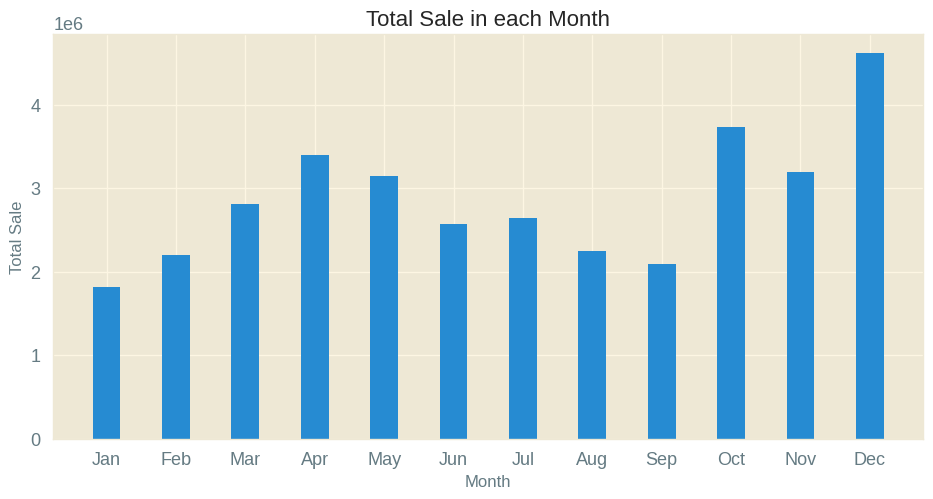

In [46]:
fig = plt.figure(figsize = (10, 5))
plt.style.use("Solarize_Light2")
# creating the bar plot
plt.bar(labels, values,
        width = 0.4)
 
plt.xlabel("Month")
plt.ylabel("Total Sale")
plt.title("Total Sale in each Month")
plt.show()

## 4. What are the key demographics of the customers?

In [31]:
import pyspark.sql.functions as F

In [32]:
df = df.withColumn('area', F.split(col('Purchase Address'), ',')[1])

In [33]:
df.show(5)

+--------+--------------------+----------------+----------+--------------+--------------------+--------------+
|Order ID|             Product|Quantity Ordered|Price Each|    Order Date|    Purchase Address|          area|
+--------+--------------------+----------------+----------+--------------+--------------------+--------------+
|  295665|  Macbook Pro Laptop|               1|      1700|12/30/19 00:01|136 Church St, Ne...| New York City|
|  295666|  LG Washing Machine|               1|     600.0|12/29/19 07:03|562 2nd St, New Y...| New York City|
|  295667|USB-C Charging Cable|               1|     11.95|12/12/19 18:21|277 Main St, New ...| New York City|
|  295668|    27in FHD Monitor|               1|    149.99|12/22/19 15:13|410 6th St, San F...| San Francisco|
|  295669|USB-C Charging Cable|               1|     11.95|12/18/19 12:38|43 Hill St, Atlan...|       Atlanta|
+--------+--------------------+----------------+----------+--------------+--------------------+--------------+
o

In [34]:
area_count = df.groupBy('area').count()
area_count.show()

+--------------+-----+
|          area|count|
+--------------+-----+
|      Portland|12465|
|       Atlanta|14881|
|          null|  355|
|        Dallas|14820|
|        Boston|19934|
|        Austin| 9905|
|   Los Angeles|29605|
| New York City|24876|
| San Francisco|44732|
|       Seattle|14732|
+--------------+-----+



In [35]:
area_labels = area_count.select("area").rdd.flatMap(lambda x: x).collect()
area_values = area_count.select("count").rdd.flatMap(lambda x: x).collect()

In [36]:
area_labels = ["Unknown" if item is None else item for item in area_labels]

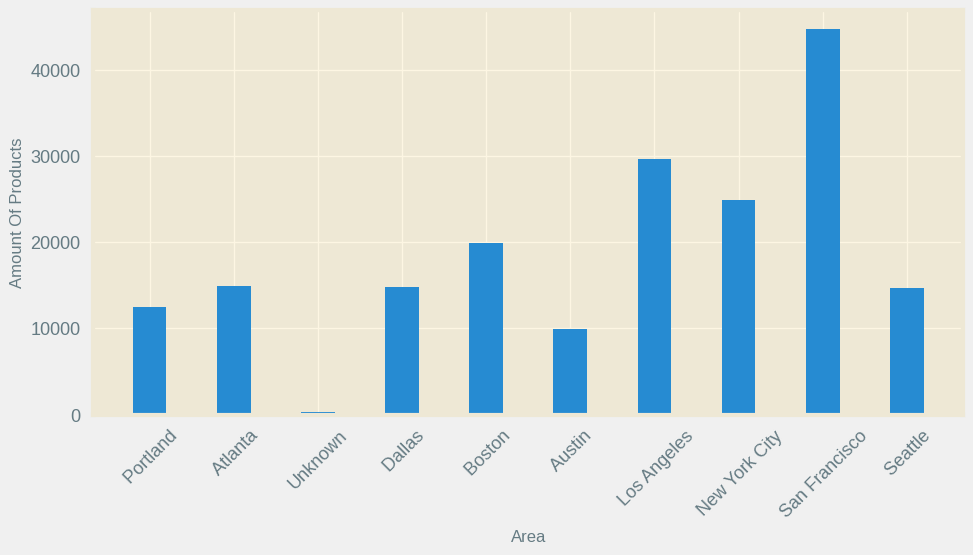

In [49]:
fig = plt.figure(figsize = (10, 5))
plt.style.use("Solarize_Light2")
# creating the bar plot
plt.bar(area_labels, area_values,
        width = 0.4)
 
plt.xlabel("Area")
plt.xticks(rotation=45)
plt.ylabel("Amount Of Products")
plt.show()

In [38]:
percentage_df = df.groupBy('area').agg((F.count('*') / F.lit(df.count()) * 100).alias('percentage'))

In [39]:
percentage_df = percentage_df.withColumn(
    'formatted_percentage',
    F.concat(F.format_number(F.col('percentage'), 2), F.lit('%'))
)
percentage_df.show()

+--------------+-------------------+--------------------+
|          area|         percentage|formatted_percentage|
+--------------+-------------------+--------------------+
|      Portland|   6.69064168970237|               6.69%|
|       Atlanta|  7.987439950618609|               7.99%|
|          null|0.19054775770913288|               0.19%|
|        Dallas| 7.9546979415474635|               7.95%|
|        Boston|  10.69965916105311|              10.70%|
|        Austin|  5.316550817208341|               5.32%|
|   Los Angeles| 15.890609484447547|              15.89%|
| New York City|  13.35229865006307|              13.35%|
| San Francisco|  24.01009097984488|              24.01%|
|       Seattle|   7.90746356780548|               7.91%|
+--------------+-------------------+--------------------+



In [40]:
percentage_labels = percentage_df.select("percentage").rdd.flatMap(lambda x: x).collect()

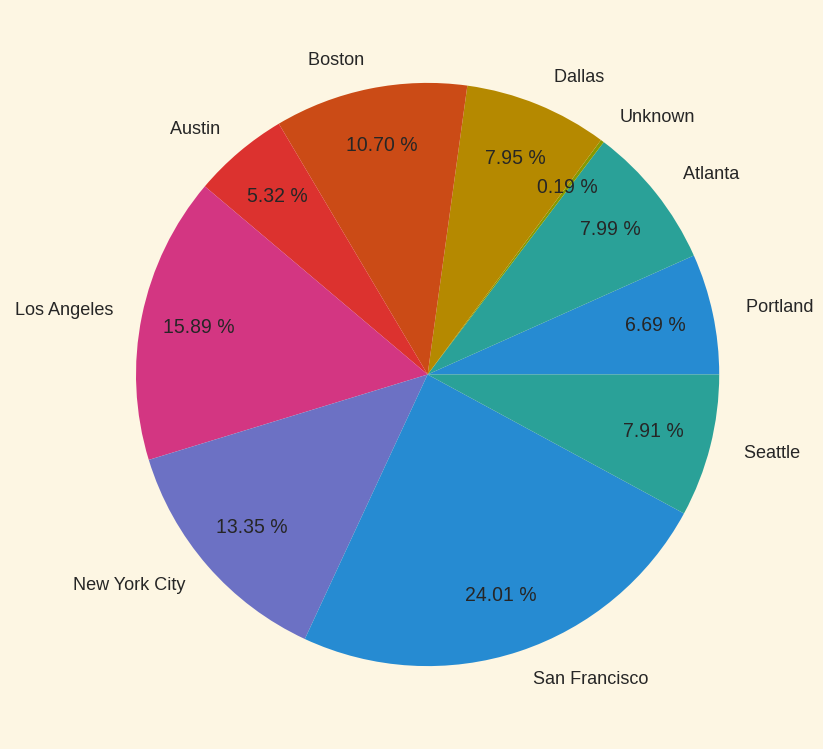

In [50]:
plt.figure(figsize=(12,9))
plt.style.use("Solarize_Light2")
plt.pie(percentage_labels, labels=area_labels, autopct='%.2f %%', pctdistance=0.8)

plt.show()

In [42]:
best_seller_df = df.groupBy('area', 'Product').agg(F.max('Quantity Ordered').alias('max_quantity'))
best_seller_per_area_df = best_seller_df.groupBy('area').agg(
    F.first('Product').alias('best_seller_product'),
    F.max('max_quantity').alias('highest_quantity')
)

best_seller_per_area_df.show()

+--------------+-------------------+----------------+
|          area|best_seller_product|highest_quantity|
+--------------+-------------------+----------------+
|          null|            Product|Quantity Ordered|
|       Atlanta|       20in Monitor|               7|
|        Austin|       20in Monitor|               7|
|        Boston|       20in Monitor|               8|
|        Dallas|       20in Monitor|               8|
|   Los Angeles|       20in Monitor|               9|
| New York City|       20in Monitor|               7|
|      Portland|       20in Monitor|               8|
| San Francisco|       20in Monitor|               9|
|       Seattle|       20in Monitor|               7|
+--------------+-------------------+----------------+



## 5. Which market (country) generated the most sales on average?

In [51]:
area_total_sale_df = df.withColumn('total', col('Quantity Ordered') * col('Price Each')) \
                  .groupBy('area') \
                  .agg(sum('total').alias('area_total_sale'))
area_total_sale_df.show()

+--------------+------------------+
|          area|   area_total_sale|
+--------------+------------------+
|      Portland| 2320490.609999995|
|       Atlanta|2795498.5799999936|
|          null|              null|
|        Dallas| 2767975.399999994|
|        Boston| 3661642.009999992|
|        Austin|1819581.7499999988|
|   Los Angeles| 5452570.799999969|
| New York City|  4664317.42999998|
| San Francisco| 8262203.909999811|
|       Seattle|2747755.4799999944|
+--------------+------------------+



In [52]:
area_total_sale_labels = area_total_sale_df.select("area").rdd.flatMap(lambda x: x).collect()
area_total_sale_labels.remove(None)
area_total_sale_values = area_total_sale_df.select("area_total_sale").rdd.flatMap(lambda x: x).collect()
area_total_sale_values.remove(None)

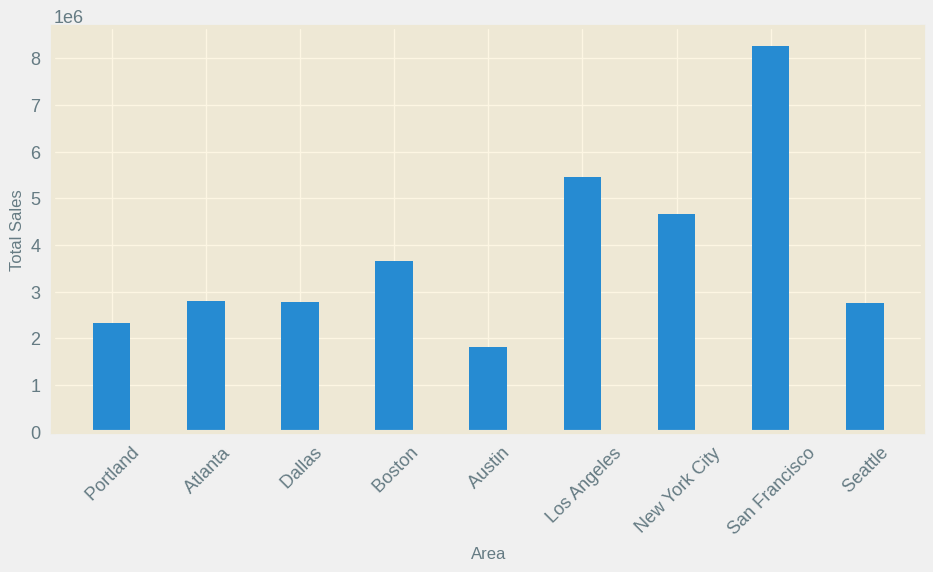

In [54]:
fig = plt.figure(figsize = (10, 5))
plt.style.use("Solarize_Light2")
# creating the bar plot
plt.bar(area_total_sale_labels, area_total_sale_values,
        width = 0.4)
 
plt.xlabel("Area")
plt.xticks(rotation=45)
plt.ylabel("Total Sales")
plt.show()

## 6. When were the best- and worst-selling periods?

In [55]:
time_df = df.withColumn('Month', F.split(df['Order Date'], '/')[0].cast('int'))
time_df.show()

+--------+--------------------+----------------+----------+--------------+--------------------+--------------+-----+
|Order ID|             Product|Quantity Ordered|Price Each|    Order Date|    Purchase Address|          area|Month|
+--------+--------------------+----------------+----------+--------------+--------------------+--------------+-----+
|  295665|  Macbook Pro Laptop|               1|      1700|12/30/19 00:01|136 Church St, Ne...| New York City|   12|
|  295666|  LG Washing Machine|               1|     600.0|12/29/19 07:03|562 2nd St, New Y...| New York City|   12|
|  295667|USB-C Charging Cable|               1|     11.95|12/12/19 18:21|277 Main St, New ...| New York City|   12|
|  295668|    27in FHD Monitor|               1|    149.99|12/22/19 15:13|410 6th St, San F...| San Francisco|   12|
|  295669|USB-C Charging Cable|               1|     11.95|12/18/19 12:38|43 Hill St, Atlan...|       Atlanta|   12|
|  295670|AA Batteries (4-p...|               1|      3.84|12/31

In [56]:
time_part = F.split(df['Order Date'], ' ')[1]
time_df = time_df.withColumn('Hour', F.split(time_part, ':')[0].cast('int'))
time_df.show()

+--------+--------------------+----------------+----------+--------------+--------------------+--------------+-----+----+
|Order ID|             Product|Quantity Ordered|Price Each|    Order Date|    Purchase Address|          area|Month|Hour|
+--------+--------------------+----------------+----------+--------------+--------------------+--------------+-----+----+
|  295665|  Macbook Pro Laptop|               1|      1700|12/30/19 00:01|136 Church St, Ne...| New York City|   12|   0|
|  295666|  LG Washing Machine|               1|     600.0|12/29/19 07:03|562 2nd St, New Y...| New York City|   12|   7|
|  295667|USB-C Charging Cable|               1|     11.95|12/12/19 18:21|277 Main St, New ...| New York City|   12|  18|
|  295668|    27in FHD Monitor|               1|    149.99|12/22/19 15:13|410 6th St, San F...| San Francisco|   12|  15|
|  295669|USB-C Charging Cable|               1|     11.95|12/18/19 12:38|43 Hill St, Atlan...|       Atlanta|   12|  12|
|  295670|AA Batteries (

In [57]:
product_in_month_df = time_df.groupBy('Product', 'Month').agg(
    F.sum('Quantity Ordered').alias('Total Orders'))
product_in_month_df.show()

+--------------------+-----+------------+
|             Product|Month|Total Orders|
+--------------------+-----+------------+
|     ThinkPad Laptop|    1|       219.0|
|        20in Monitor|    1|       218.0|
|     ThinkPad Laptop|   12|       539.0|
|        Google Phone|   12|       715.0|
|Bose SoundSport H...|    1|       662.0|
|        Google Phone|    1|       319.0|
|Apple Airpods Hea...|   12|      2076.0|
|        20in Monitor|   12|       569.0|
|27in 4K Gaming Mo...|    1|       313.0|
|    Wired Headphones|   12|      2749.0|
|    Wired Headphones|    1|      1085.0|
|AA Batteries (4-p...|   12|      3724.0|
|USB-C Charging Cable|    1|      1287.0|
|              iPhone|    1|       381.0|
|Apple Airpods Hea...|    1|       818.0|
|              iPhone|   12|       906.0|
|    27in FHD Monitor|    1|       422.0|
|27in 4K Gaming Mo...|   12|       864.0|
|Bose SoundSport H...|   12|      1824.0|
|34in Ultrawide Mo...|   12|       849.0|
+--------------------+-----+------

In [58]:
total_in_month = product_in_month_df.groupBy('Month').agg(
    F.sum('Total Orders').alias('Total Orders'))
total_in_month.show()

+-----+------------+
|Month|Total Orders|
+-----+------------+
|   12|     28114.0|
| null|        null|
|    1|     10903.0|
|    6|     15253.0|
|    3|     17005.0|
|    5|     18667.0|
|    9|     13109.0|
|    4|     20558.0|
|    8|     13448.0|
|    7|     16072.0|
|   10|     22703.0|
|   11|     19798.0|
|    2|     13449.0|
+-----+------------+



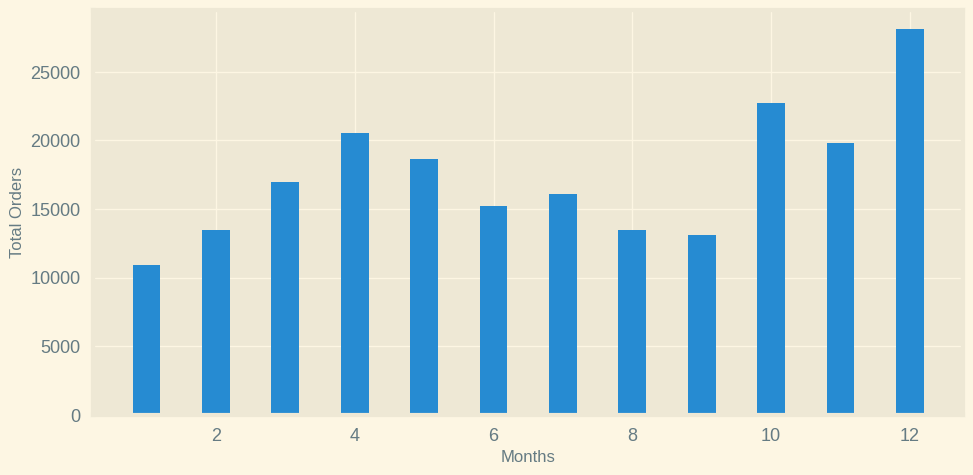

In [59]:
total_in_month_df = total_in_month.toPandas()
fig = plt.figure(figsize = (10, 5))
plt.style.use("Solarize_Light2")

# creating the bar plot
plt.bar(total_in_month_df["Month"], total_in_month_df["Total Orders"],
        width = 0.4)
 
plt.xlabel("Months")
plt.ylabel("Total Orders")
plt.show()

In [60]:
import seaborn as sns

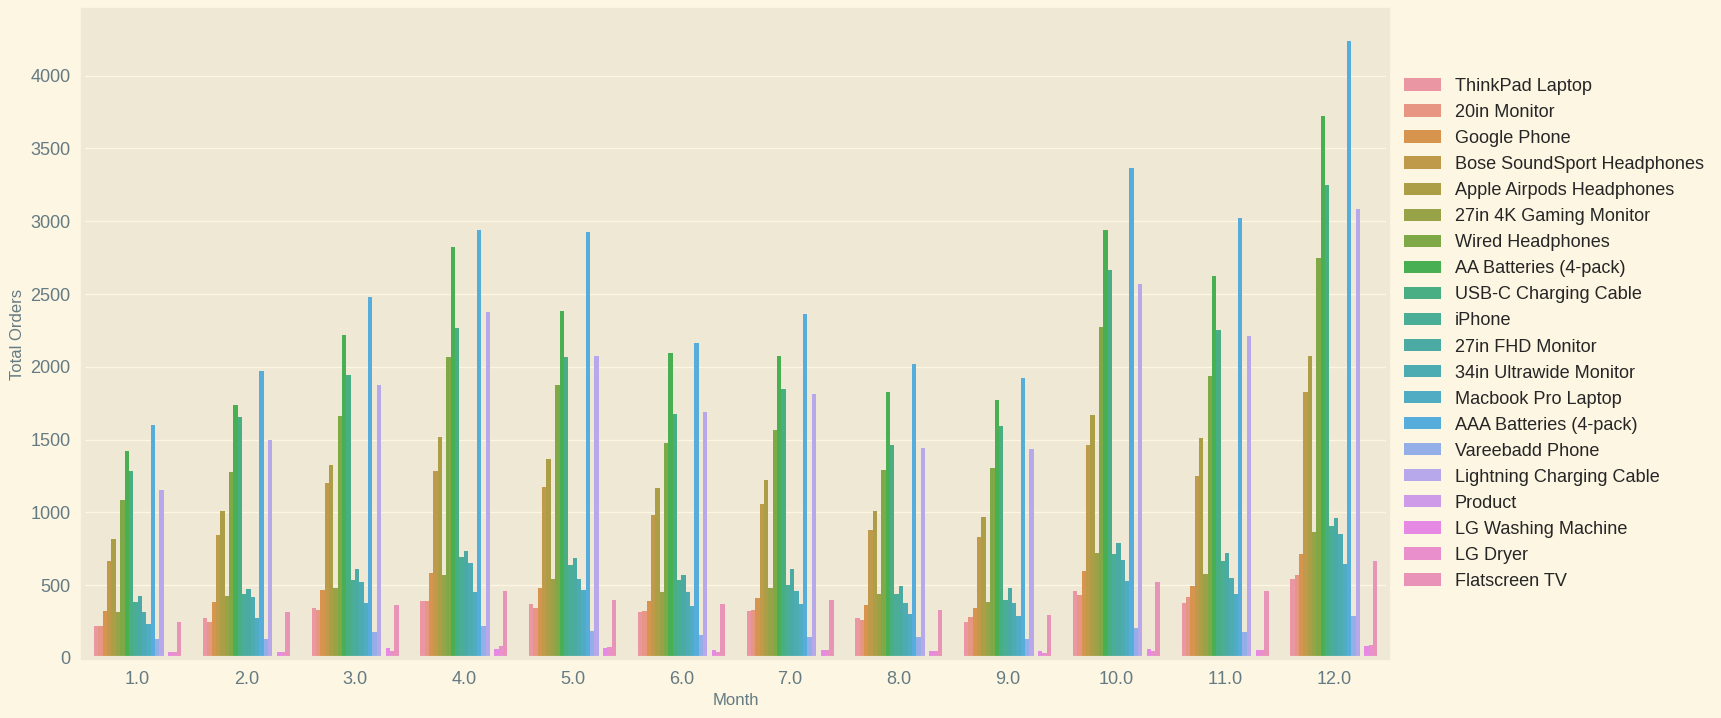

In [61]:
result_df = product_in_month_df.toPandas()

plt.figure(figsize=(15, 8))
plt.style.use("Solarize_Light2")
ax = sns.barplot(data=result_df, x = "Month", y ="Total Orders",hue='Product')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [62]:
df_december = product_in_month_df.filter(product_in_month_df['Month'] == 12)
df_december.show()

+--------------------+-----+------------+
|             Product|Month|Total Orders|
+--------------------+-----+------------+
|     ThinkPad Laptop|   12|       539.0|
|        Google Phone|   12|       715.0|
|Apple Airpods Hea...|   12|      2076.0|
|        20in Monitor|   12|       569.0|
|    Wired Headphones|   12|      2749.0|
|AA Batteries (4-p...|   12|      3724.0|
|              iPhone|   12|       906.0|
|27in 4K Gaming Mo...|   12|       864.0|
|Bose SoundSport H...|   12|      1824.0|
|34in Ultrawide Mo...|   12|       849.0|
|  Macbook Pro Laptop|   12|       643.0|
|AAA Batteries (4-...|   12|      4241.0|
|     Vareebadd Phone|   12|       284.0|
|Lightning Chargin...|   12|      3087.0|
|    27in FHD Monitor|   12|       962.0|
|USB-C Charging Cable|   12|      3250.0|
|  LG Washing Machine|   12|        80.0|
|            LG Dryer|   12|        86.0|
|       Flatscreen TV|   12|       666.0|
+--------------------+-----+------------+



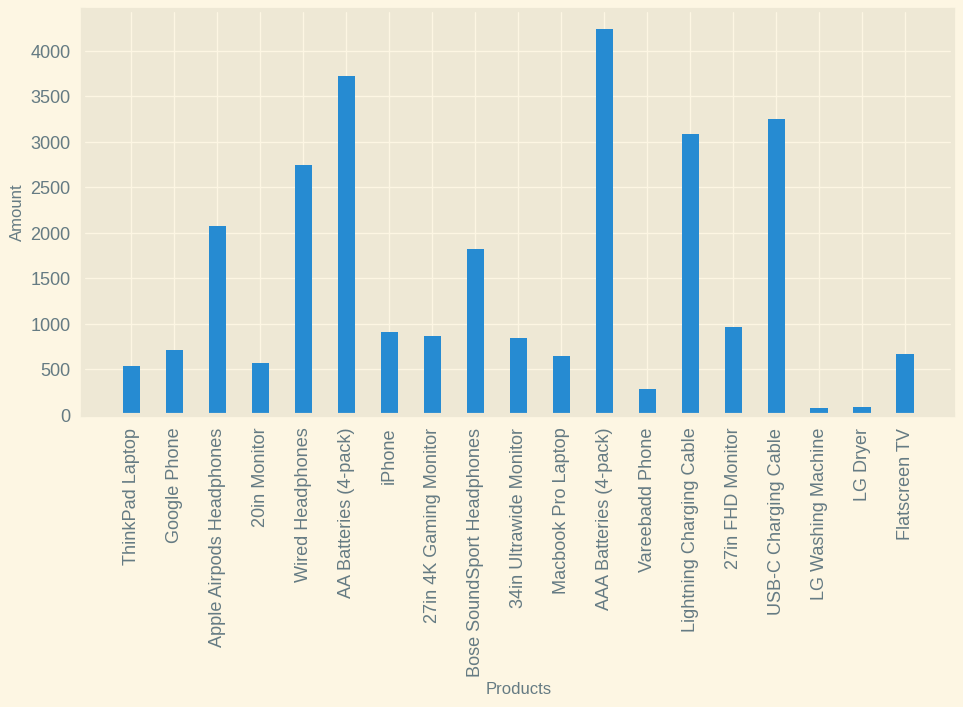

In [63]:
df_dec_pd = df_december.toPandas()
fig = plt.figure(figsize = (10, 5))
plt.style.use("Solarize_Light2")
# creating the bar plot
plt.bar(df_dec_pd["Product"], df_dec_pd["Total Orders"],
        width = 0.4)
 
plt.xlabel("Products")
plt.xticks(rotation=90)
plt.ylabel("Amount")
plt.show()

In [64]:
product_in_hour_df = time_df.groupBy('Hour').agg(
    F.sum('Quantity Ordered').alias('Total Orders'))
product_in_hour_df = product_in_hour_df.na.drop()
product_in_hour_df = product_in_hour_df.orderBy("Hour")
product_in_hour_df.show(24)

+----+------------+
|Hour|Total Orders|
+----+------------+
|   0|      4428.0|
|   1|      2619.0|
|   2|      1398.0|
|   3|       928.0|
|   4|       937.0|
|   5|      1493.0|
|   6|      2810.0|
|   7|      4556.0|
|   8|      7002.0|
|   9|      9816.0|
|  10|     12308.0|
|  11|     14005.0|
|  12|     14202.0|
|  13|     13685.0|
|  14|     12362.0|
|  15|     11391.0|
|  16|     11662.0|
|  17|     12229.0|
|  18|     13802.0|
|  19|     14470.0|
|  20|     13768.0|
|  21|     12244.0|
|  22|      9899.0|
|  23|      7065.0|
+----+------------+



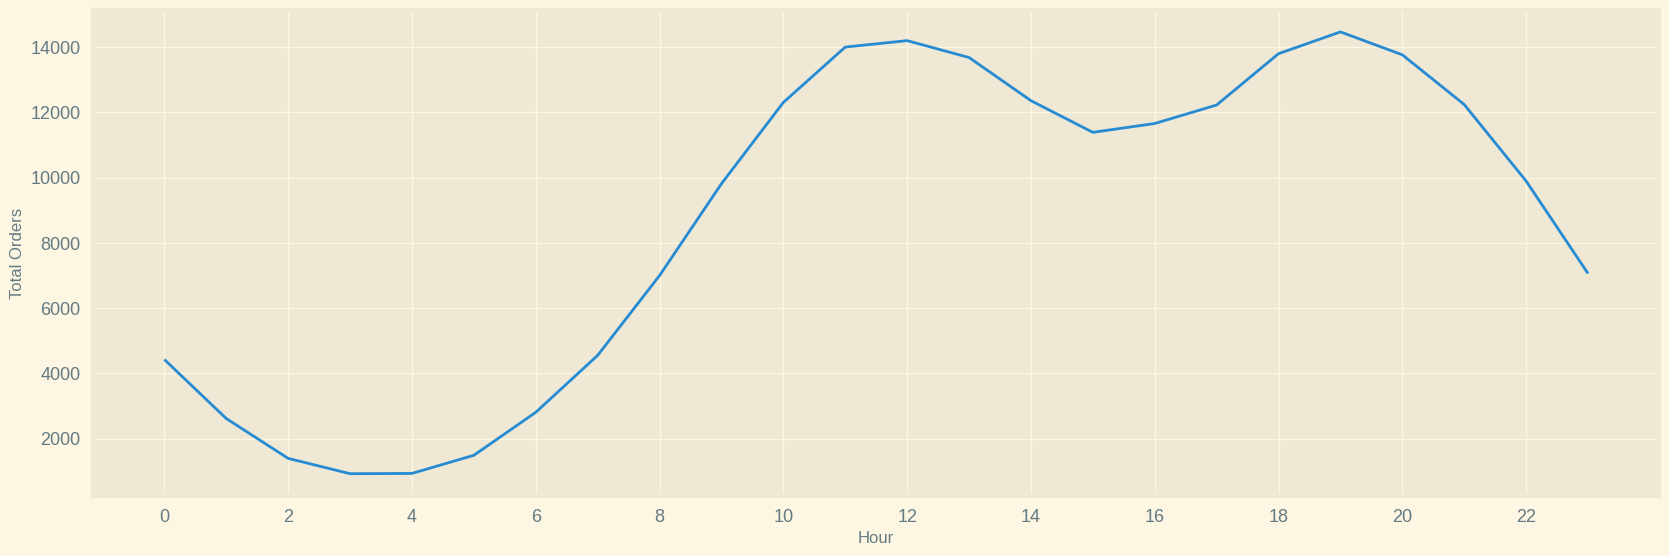

In [65]:
dt = product_in_hour_df.toPandas()
plt.figure(figsize=(18, 6))
plt.style.use("Solarize_Light2")
# sns.relplot(data=dt, x=dt["Hour"], y=dt["Total Orders"], kind="line")
plt.plot(dt["Hour"], dt["Total Orders"])
plt.xlabel("Hour")
plt.xticks(range(0,24,2))
plt.ylabel("Total Orders")
plt.show()

## 7. Which products sell best?

In [66]:
grouped_df = df.groupBy('Product').agg(
    F.sum('Quantity Ordered').alias('Total Orders'),
    F.sum(F.col('Quantity Ordered') * F.col('Price Each')).alias('Total Sale')
)

# Show the resulting dataframe
grouped_df.show()

+--------------------+------------+------------------+
|             Product|Total Orders|        Total Sale|
+--------------------+------------+------------------+
|    Wired Headphones|     20557.0| 246478.4300000033|
|  Macbook Pro Laptop|      4728.0|         8037600.0|
|Apple Airpods Hea...|     15661.0|         2349150.0|
|              iPhone|      6849.0|         4794300.0|
|Lightning Chargin...|     23217.0|347094.15000000555|
|Bose SoundSport H...|     13457.0|1345565.4300000141|
|USB-C Charging Cable|     23975.0|286501.25000000757|
|AAA Batteries (4-...|     31017.0| 92740.82999999689|
|        20in Monitor|      4129.0|454148.71000000066|
|    27in FHD Monitor|      7550.0|1132424.5000000072|
|     Vareebadd Phone|      2068.0|          827200.0|
|34in Ultrawide Mo...|      6199.0|2355558.0099999895|
|            LG Dryer|       646.0|          387600.0|
|AA Batteries (4-p...|     27635.0| 106118.4000000023|
|        Google Phone|      5532.0|         3319200.0|
|       Fl

In [ ]:
products = grouped_df.select("Product").rdd.flatMap(lambda x: x).collect()
products.remove("Product")
total_orders = grouped_df.select("Total Orders").rdd.flatMap(lambda x: x).collect()
total_orders.remove(None)
total_sales = grouped_df.select("Total Sale").rdd.flatMap(lambda x: x).collect()
total_sales.remove(None)

In [ ]:
fig, ax1 = plt.subplots(figsize=(24, 14))
plt.style.use("Solarize_Light2")
ax2 = ax1.twinx()

ax1.bar(products, total_orders)
ax1.set_title(
    "Product with the Price",
    weight="bold",
    fontname="monospace",
    fontsize=35,
    pad=30 
)
ax1.set_xlabel(
    "Product Names",
    weight="bold",
    fontsize=25,
    color="black"
)
ax1.set_ylabel(
    "Total Orders", 
    color="blue",
    fontsize=20,
    weight="bold"
)
ax1.set_xticklabels(
    products,
    rotation=60, 
    weight="bold"
)

ax2.plot(
    products,
    total_sales,
    "r-"
)
ax2.set_ylabel(
    "Total Sale in USD ($)", 
    color="green",
    fontsize=20,
    weight="bold"
);


In [ ]:
spark.stop()